##Xây dựng mô hình word2vec cho Tiếng Việt




### Import thư viện

In [ ]:
import gensim.models.fasttext as FastText
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec, KeyedVectors
import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Load dữ liệu

In [ ]:
# load tập stop_word
stopword = pd.read_csv('/content/drive/My Drive/Tạm thời/stopwords.csv')
stopword_list = stopword['stopwords'].to_list()
stopword_list[0:10]

['mà_thôi',
 'tuy_có',
 'đâu_như',
 'quay_bước',
 'hỏi_lại',
 'khẳng_định',
 'giờ_này',
 'ren_rén',
 'một_cơn',
 'ủa']

In [ ]:
# load bộ dữ liệu
DATA_PATH = '/content/drive/My Drive/Tạm thời/datatrain.txt'
pd.options.display.max_colwidth = 200

def load_data(path):
    lines = {}
    with open(path, "r", encoding = 'utf-8') as f:
        file = f.read()

        # file = file.replace('\n', '')
        # file = file.replace(',', ' ')
        # file = file.lower()
        file = re.sub(r'[\d]+', '', file)
        sentences = re.split(r'\n', file)
        lines['text'] = sentences
    df = pd.DataFrame(lines)
    return df

frame = load_data(DATA_PATH)
frame.head(10)

,text
0,danh_sách tác_phẩm doraemon
1,doraemon nguyên_tác là xê ri anime và manga được sáng_tác bởi fujiko_f
2,bắt_đầu_từ những chương truyện nhỏ đăng trên tạp_chí tháng corocoro comic sau đó shogakukan tập_hợp lại phát_hành theo cuốn từ tập đến tập
3,sau đó chuyển_thể thành anime theo ba giai_đoạn phim hoạt_hình và
4,năm viz_media mua bản_quyền mỹ_hóa các yếu_tố trong phim như tên nhân_vật địa_điểm
5,và phát_sóng trên disney xd kể từ tháng
6,xê ri cũng được chuyển_thể thành nhiều tác_phẩm khác nhau như doraemon_plus truyện_ngắn truyện_dài phim điện_ảnh trò_chơi điện_tử nhạc_kịch băng_đĩa
7,dưới đây là danh_sách các tác_phẩm về doraemon được phát_hành
8,được ra_mắt lần đầu dưới dạng các chương truyện riêng_lẻ được đăng trên các tạp_chí khác nhau của shogakukan từ
9,sau đó được tập_hợp lại thành cuốn phát_hành có tổng_cộng tập truyện_ngắn ra_đời


### Tiền xử lý dữ liệu

In [ ]:
# loại bỏ stopword
corpus = []
for row in frame['text']:
    corpus.append([w for w in row.split() if w not in stopword_list])
corpus[:10]

[['danh_sách', 'tác_phẩm', 'doraemon'],
 ['doraemon',
  'nguyên_tác',
  'xê',
  'ri',
  'anime',
  'manga',
  'sáng_tác',
  'fujiko_f'],
 ['chương',
  'truyện',
  'đăng',
  'tạp_chí',
  'corocoro',
  'comic',
  'shogakukan',
  'tập_hợp',
  'phát_hành',
  'tập',
  'tập'],
 ['chuyển_thể', 'thành', 'anime', 'giai_đoạn', 'phim', 'hoạt_hình'],
 ['viz_media',
  'mua',
  'bản_quyền',
  'mỹ_hóa',
  'yếu_tố',
  'phim',
  'nhân_vật',
  'địa_điểm'],
 ['phát_sóng', 'disney', 'xd'],
 ['xê',
  'ri',
  'chuyển_thể',
  'thành',
  'tác_phẩm',
  'doraemon_plus',
  'truyện_ngắn',
  'truyện_dài',
  'phim',
  'điện_ảnh',
  'trò_chơi',
  'điện_tử',
  'nhạc_kịch',
  'băng_đĩa'],
 ['danh_sách', 'tác_phẩm', 'doraemon', 'phát_hành'],
 ['ra_mắt',
  'đầu',
  'dạng',
  'chương',
  'truyện',
  'riêng_lẻ',
  'đăng',
  'tạp_chí',
  'shogakukan'],
 ['tập_hợp',
  'thành',
  'phát_hành',
  'tổng_cộng',
  'tập',
  'truyện_ngắn',
  'ra_đời']]

In [ ]:
#tạo từ điển dạng {word: count} cho tập dữ liệu
from collections import defaultdict
word_frequence = defaultdict(int)
for line in corpus:
    for word in line:
        word_frequence[word]+=1
len(word_frequence)

185296

In [ ]:
#thống kê các từ xuất hiện nhiều
sorted(word_frequence, key = word_frequence.get, reverse= True)[0:20]

['loài',
 'khoa_học',
 'miêu_tả',
 'bọ',
 'hoa',
 'thực_vật',
 'cánh_cứng',
 'mô_tả',
 'chim',
 'hai',
 'dân_số',
 'tỉnh',
 'việt_nam',
 'pháp',
 'hoa_kỳ',
 'quân',
 'thành',
 'đi',
 'tiếng',
 'thành_phố']

### Xây dựng mô hình và huấn luyện

In [ ]:
from gensim.models import Word2Vec, KeyedVectors

w2v_model = Word2Vec(min_count=5,	#bỏ qua những từ có tần số xuất hiện <5
                    window=5,		#khoảng cách tối đa của center word và context word
                    size=300, 		 #kích thước của word-vector
                    sample=6e-5,	 #ngưỡng loại bỏ cho supsampling frequent word
                    alpha=0.01, 	 #tỷ lệ học ban đầu
                    min_alpha=0.0007, #tỷ lệ học sẽ giảm tuyến tính xuống min_alpha
                    negative=20,      #tỷ lệ negative sampling 
                    sg = 1)		#sử dụng skip-gram(1) còn cbow (0)


In [ ]:
# tạo tập từ vựng cho mô hình
from time import time 
t = time()

w2v_model.build_vocab(corpus, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.11 mins


In [ ]:
# huấn luyện mô hình
w2v_model.train(corpus, total_examples=w2v_model.corpus_count, epochs=5, report_delay=1)

(7662380, 12911800)

In [ ]:
# lưu lại mô hình đã huấn luyện
w2v_model.wv.save('/content/drive/My Drive/Tạm thời/w2v_skipgram.model')

### Kết quả mô hình

In [ ]:
w2v_model.wv.most_similar(positive=["thực_vật"])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('hoa', 0.9952279329299927),
 ('cactaceae', 0.9474865794181824),
 ('thảo', 0.9460049867630005),
 ('mã_đề', 0.9232586622238159),
 ('crassulaceae', 0.9145495891571045),
 ('hồng_xiêm', 0.911345362663269),
 ('cánh_cứng', 0.9110461473464966),
 ('bọ', 0.9074221253395081),
 ('loài', 0.8994311094284058),
 ('rhynchitidae', 0.8895726203918457)]

In [ ]:
w2v_model.wv.most_similar(positive=["văn_xuôi"])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('thi_ca', 0.9984006285667419),
 ('thơ_ca', 0.9979225397109985),
 ('trinh_thám', 0.997155487537384),
 ('truyện_cổ_tích', 0.9967832565307617),
 ('truyện_kiều', 0.9967100620269775),
 ('ấn_hành', 0.9966393709182739),
 ('hội_họa', 0.9965036511421204),
 ('hoạ_sĩ', 0.9963455200195312),
 ('tiểu_luận', 0.9962296485900879),
 ('johann', 0.9961010217666626)]

### Minh họa kết quả

In [ ]:
list_words = list(w2v_model.wv.vocab)[100:200]
words_vector = []
for word in list_words:
  words_vector.append(w2v_model.wv[word])


In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


In [ ]:
pca = PCA(n_components=2)
pca.fit(words_vector)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
reduced = pca.transform(words_vector)

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65281 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 65281 missing from current font.
  font.set_text(s, 0, flags=flags)


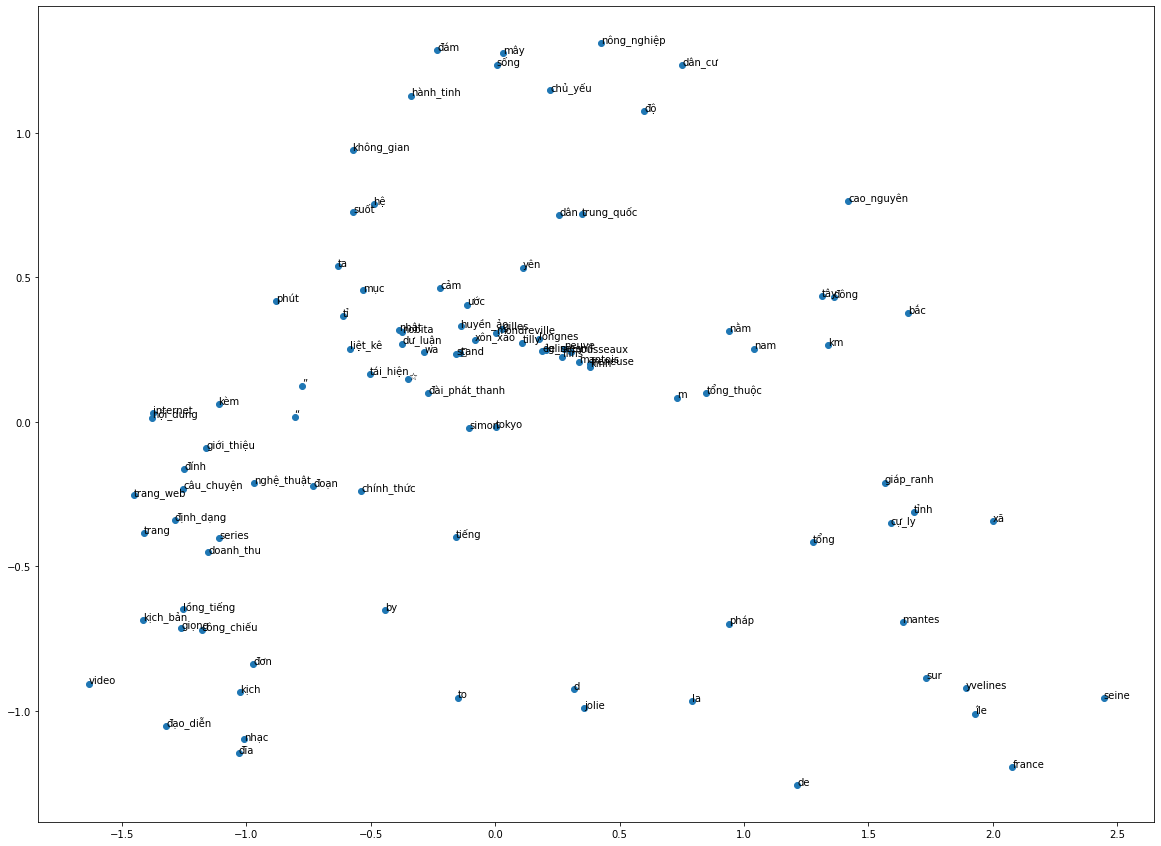

In [ ]:
plt.figure(figsize = (20, 15))
plt.scatter(reduced[:, 0], reduced[:, 1])
for i, word in enumerate(list_words):
  plt.annotate(word, (reduced[i][0], reduced[i][1]))

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12539 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12539 missing from current font.
  font.set_text(s, 0, flags=flags)


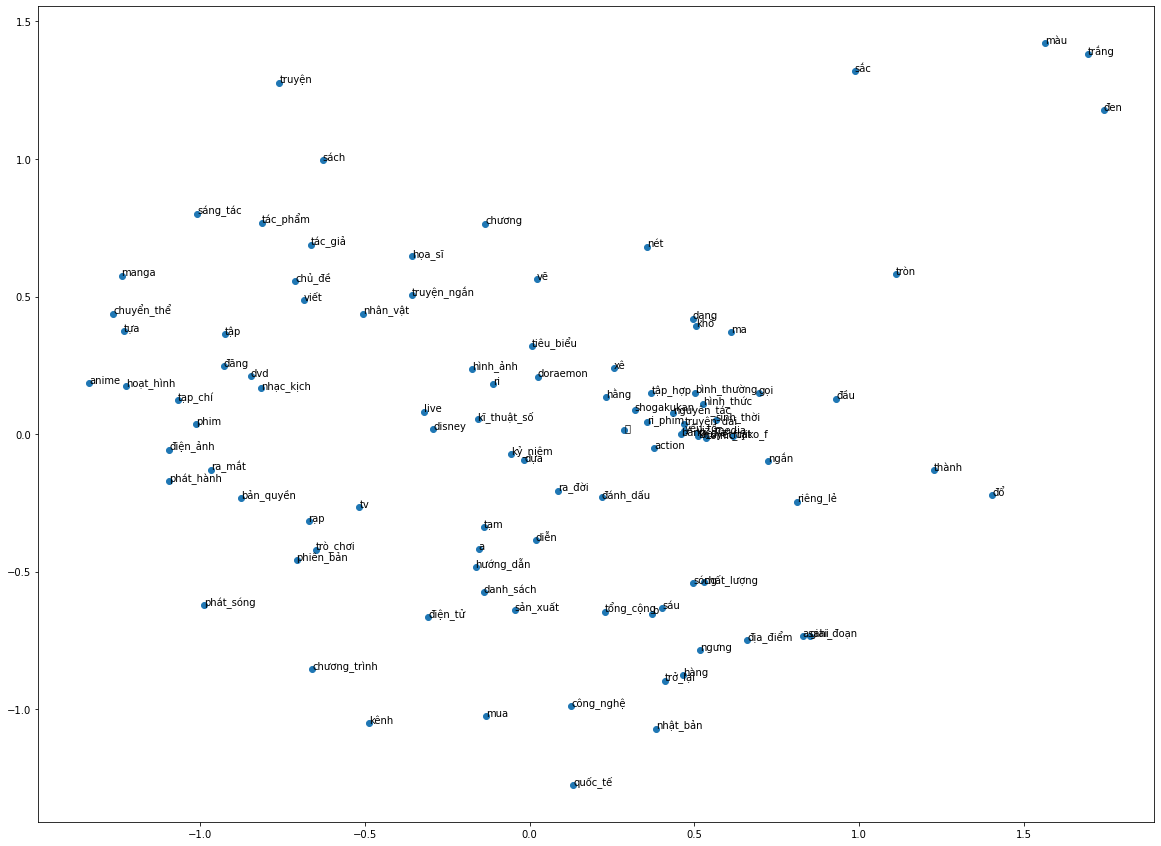

In [ ]:
plt.figure(figsize = (20, 15))
plt.scatter(reduced[:, 0], reduced[:, 1])
for i, word in enumerate(list_words):
  plt.annotate(word, (reduced[i][0], reduced[i][1]))